In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import copy

In [3]:
folder = 'data/'
state = 'fl_statewide_2020_04_01.csv'
state2 = 'ca_long_beach_2020_04_01.csv'

# Preprocessing whole dataset (do not execute if working on full data)

In [ ]:
df_full = pd.read_csv(folder + state)
print(df_full.columns)

Reducing the amount of data for experimentation

In [ ]:
cut_file_path = folder + state.split('.')[0] + "_cut.csv"
total_size = df_full.shape[0]
df = df_full.sample(n=int(total_size/100))
print("Full dataset of size {} was reduced to subset of {} elements.".format(total_size, df.shape[0]))
df.to_csv(cut_file_path, index = False)

# Load the data (currently loading all data)

In [4]:
df =  pd.read_csv(folder + state)
print("Dataset is composed of {} stops. Columns are: \n".format(df.shape[0]))
for col in df.columns:
    if df.dtypes[col] != np.float64:
        val = df[col].unique()
        if len(val) > 20:
            print('{} \t\t: too much different values'.format(col))
        else:
            print('{} \t\t: values are: {}'.format(col if len(col)>15 else col + "\t\t", val))
df = df.rename(columns={'officer_years_of_service': 'officer_yos'})

Dataset is composed of 7297538 stops. Columns are: 

raw_row_number 		: too much different values
date 		: too much different values
time 		: too much different values
location 		: too much different values
county_name 		: too much different values
subject_race		 		: values are: [nan 'white' 'black' 'hispanic' 'asian/pacific islander' 'other' 'unknown']
subject_sex		 		: values are: ['female' 'male' nan]
officer_id_hash 		: too much different values
officer_race		 		: values are: [nan 'black' 'white' 'hispanic' 'unknown' 'asian/pacific islander' 'other']
officer_sex		 		: values are: [nan 'male' 'female']
department_name		 		: values are: ['FLORIDA HIGHWAY PATROL' 'FLORIDA HIGHWAY PATROL - TROOP K'
 'FLORIDA HIGHWAY PATROL  MOTORS SQ' 'FLORIDA DEPARTMENT OF AGRICULTURE'
 nan]
unit 		: too much different values
type		 		: values are: ['vehicular']
violation 		: too much different values
arrest_made		 		: values are: [nan False True]
citation_issued		 		: values are: [True False nan]
war

In [ ]:
for i, n in enumerate(df['raw_EnforcementAction']):
    print(n)
    if i == 100:
        break

# Preprocess to compare search rates

Calculate search rates for each officer race and each subject race across each county

# General functions

In [6]:
minority_race = ['black', 'hispanic']

def remove_general_unused_columns(data, keep=[]):
    columns_unused = ['officer_id_hash', 'vehicle_registration_state', 'type']
    columns_reasons = ['reason_for_stop', 'reason_for_search', 'notes', 'violation', 'search_basis']
    columns_raw = ['raw_EnforcementAction', 'raw_SearchType', 'raw_Ethnicity', 'raw_row_number_new', 'raw_Race', 'raw_row_number_old', 'raw_row_number']
    columns_geography = ['location', 'date','time', 'department_name', 'unit']
    general_columns_to_remove=columns_unused + columns_reasons + columns_raw + columns_geography
    return data.drop(columns=[ x for x in general_columns_to_remove if x not in keep])

def print_search_rate(data):
    number_stops = data['search_conducted'].shape[0]
    number_search_conducted = data[data['search_conducted'] == True].shape[0]
    print('Data contains {} stops and {} of them ({}%) resulted in searches.'.format(number_stops, number_search_conducted, 100 * float(number_search_conducted)/number_stops))

def preprocess_for_grouping(data):
    data['search_rate'] = data['search_conducted']
    data = data.astype({'search_rate': float})
    data['count'] = 1 # to count occurences
    return data

def separate_data(data, categories):
    df = {}
    for exp in categories:
        df[exp] = data.loc[exp]
    return df


In [ ]:
from scipy.stats import linregress

def plot_race(data, min_race, categories, threshold, what_to_plot, ax_limits=None):

    fig, ax_arr = plt.subplots(1, len(categories)) # 2 graphs
    fig.set_size_inches(14,5) # fig size
    fig.suptitle(min_race.title() + " people search rates among officers".format(min_race))

    for i, off_feat in enumerate(categories):

        data_ = data[off_feat]
        df_white_sub, df_minority = data_.loc['white'], data_.loc[min_race] #separate data
        df_white_sub.reset_index(inplace=True), df_minority.reset_index(inplace=True) #reset index
        df_merged = pd.merge(df_white_sub, df_minority, on='county_name', suffixes=['_white', '_minority']) # merge both

        # remove where there are too little datapoints
        cond_minority = df_merged['count_minority'] >= threshold

        y = df_merged[what_to_plot + '_minority'][cond_minority]*100
        x = df_merged[what_to_plot + '_white'][cond_minority]*100 if what_to_plot == 'search_rate' else pd.Series([i for i in range(y.shape[0])])
        s = df_merged['count_minority'][cond_minority]/100

        ax_arr[i].scatter(x, y, s=s, c="None", edgecolors='black', linewidth=0.4)
        ax_arr[i].set_xlabel("White " + what_to_plot + " (%)")
        ax_arr[i].set_ylabel(min_race.title() + " "+ what_to_plot +" (%)")

        #plot regression
        a, b, r, p_value, std_err = linregress(x, y)
        sns.regplot(x=x.repeat(s), y=y.repeat(s), ax=ax_arr[i], label='{:.1f}*x + {:.1f}, r={:.2f}'.format(a,b,r), scatter=False, truncate=False).legend(loc="best")

        ax_arr[i].set_title(off_feat.title() +' officers')

        if ax_limits:
            ax_arr[i].set_xlim((0,ax_limits['x']))
            ax_arr[i].set_ylim((0,ax_limits['y']))

        if what_to_plot == 'search_rate':
            # draw dotted line
            max_ = df_merged[what_to_plot + '_minority'][cond_minority].max()
            line = np.arange(0, max_ * 100, max_)
            ax_arr[i].plot(line, line, c='black', linestyle=(0,(5,5)), linewidth=1)


def plot_search_rates(data, categories, threshold=500, what_to_plot='search_rate', ax_limits=None):
    for i, race in enumerate(minority_race):
        plot_race(data, race, categories, threshold, what_to_plot, ax_limits[i] if ax_limits else None)


# # separate data
# df_race_sep = separate_data(df_race_mixed, officer_race)
# df_race_sep[officer_race[0]].head(2)

# # plot it 
# plot_search_rates(df_race_sep, officer_race, 100, what_to_plot='stop_rate')

# Race of officer

In [ ]:
officer_race = ['white', 'black', 'hispanic']

In [ ]:
df_race = copy(df)

# remove unused columns
df_race = remove_general_unused_columns(df_race)

# make sure that required data are present (drop if nan values in those columns)
important_features = ['subject_race', 'officer_race', 'search_conducted']
df_race.dropna(inplace=True, subset=important_features)
print('Cleaned subset is composed of {} datapoints'.format(df_race.shape[0]))

# overview of all the data / global search rate
print_search_rate(df_race)

# preprocess for grouping
df_race = preprocess_for_grouping(df_race)



# add specific column for this type of analyzis
df_race_all = df_race.groupby(['officer_race','subject_race','county_name']).agg({'search_rate': 'mean', 'count':'count'})
df_race_all.head(10)

In [ ]:

# df_race_all_s = df_race.groupby(['officer_race','county_name', 'subject_race']).agg({'count':'count', 'search_rate':'identity'})
# df_race_all = df_race.groupby(['officer_race','county_name']).agg({'count':'count'})
# df_race_mixed = copy(df_race_all_s)
# df_race_mixed['tot'] = df_race_all['count']
# df_race_mixed['stop_rate'] = df_race_mixed['count'] / df_race_mixed['tot']
# df_race_mixed.head(10)


In [ ]:
# separate data
df_race_sep = separate_data(df_race_all, officer_race)
df_race_sep[officer_race[0]].head(2)

# plot it 
plot_search_rates(df_race_sep, officer_race, 2000)

In [ ]:
total

# Experience of officer

In [ ]:
officer_experience_level = ['young', 'experienced', 'old']
thresholds_experience = [2, 9]

Preprocess the data to have what is needed

In [ ]:
df_yos = copy(df)

# remove unused columns
df_yos = remove_general_unused_columns(df_yos)

# make sure that required data are present (drop if nan values in those columns)
important_features = ['subject_race', 'officer_yos', 'search_conducted']
df_yos.dropna(inplace=True, subset=important_features)
print('Cleaned subset is composed of {} datapoints'.format(df_yos.shape[0]))

# overview of all the data / global search rate
print_search_rate(df_yos)

# preprocess for grouping
df_yos = preprocess_for_grouping(df_yos)

# add specific column for this type of analyzis
df_yos['age_category'] = df_yos['officer_yos'].apply(lambda x : officer_experience_level[0] if x < thresholds_experience[0] else (officer_experience_level[1] if x < thresholds_experience[1] else officer_experience_level[2]))
df_yos_all = df_yos.groupby(['age_category','subject_race','county_name']).agg({'search_rate': 'mean', 'count':'count'})

In [ ]:
# separate data
df_yos_sep = separate_data(df_yos_all, officer_experience_level)
df_yos_sep[officer_experience_level[0]].head(2)

# plot it 
plot_search_rates(df_yos_sep, officer_experience_level, 3000, ax_limits=[ {'x': 1.5, 'y':5},{'x': 1.5, 'y':2.6}]) #

# Age of the officer

In [ ]:
officer_age_level = ['young', 'experienced', 'old']
thresholds_age = [32, 45]

In [ ]:
df_age = copy(df)

# remove unused columns
df_age = remove_general_unused_columns(df_age)

# make sure that required data are present (drop if nan values in those columns)
important_features = ['subject_race', 'officer_age', 'search_conducted']
df_age.dropna(inplace=True, subset=important_features)
print('Cleaned subset is composed of {} datapoints'.format(df_age.shape[0]))

# overview of all the data / global search rate
print_search_rate(df_age)

# preprocess for grouping
df_age = preprocess_for_grouping(df_age)

# add specific column for this type of analyzis
df_age['age_category'] = df_age['officer_age'].apply(lambda x : officer_age_level[0] if x < thresholds_age[0] else (officer_age_level[1] if x < thresholds_age[1] else officer_age_level[2]))
df_age_all = df_age.groupby(['age_category','subject_race','county_name']).agg({'search_rate': 'mean', 'count':'count'})

In [ ]:
# separate data
df_age_sep = separate_data(df_age_all, officer_age_level)
df_age_sep[officer_age_level[0]].head(2)

# plot it 
plot_search_rates(df_age_sep, officer_age_level, 3000, ax_limits=[{'x': 2, 'y':4},{'x': 2, 'y':3}])

# Gender of the officer

In [ ]:
officer_sex = ['male', 'female']

In [ ]:
df_sex = copy(df)

# remove unused columns
df_sex = remove_general_unused_columns(df_sex)

# make sure that required data are present (drop if nan values in those columns)
important_features = ['subject_race', 'officer_sex', 'search_conducted']
df_sex.dropna(inplace=True, subset=important_features)
print('Cleaned subset is composed of {} datapoints'.format(df_sex.shape[0]))

# overview of all the data / global search rate
print_search_rate(df_sex)

# preprocess for grouping
df_sex = preprocess_for_grouping(df_sex)

# add specific column for this type of analyzis
# df_gender['age_category'] = df_gender['officer_gender'].apply(lambda x : officer_age_level[0] if x < thresholds_age[0] else (officer_age_level[1] if x < thresholds_age[1] else officer_age_level[2]))
df_sex_all = df_sex.groupby(['officer_sex','subject_race','county_name']).agg({'search_rate': 'mean', 'count':'count'})

In [ ]:
# separate data
df_sex_sep = separate_data(df_sex_all, officer_sex)

avg_female = df_sex_sep['female']['search_rate'].mean()
avg_male = df_sex_sep['male']['search_rate'].mean()

df_sex_sep['female']['search_rate'] = df_sex_sep['female']['search_rate'].apply(lambda x : (avg_male/avg_female)*x)
# df_sex_sep[officer_age_level[0]].head(2)

# plot it 
plot_search_rates(df_sex_sep, officer_sex, 500)#, ax_limits=[{'x': 1.25, 'y':3.5},{'x': 2, 'y':3}])

# Importance of characteristics of officer for stop_rate

# Race of the officer (with stop_rate)

In [ ]:
officer_race = ['white', 'black', 'hispanic']

In [ ]:
df_race = copy(df)

# make sure that required data are present (drop if nan values in those columns)
important_features = ['subject_race', 'officer_race', 'search_conducted']
df_race.dropna(inplace=True, subset=important_features)
print('Cleaned subset is composed of {} datapoints'.format(df_race.shape[0]))

# overview of all the data / global search rate
print_search_rate(df_race)
df_race = preprocess_for_grouping(df_race)

# add specific column for this type of analyzis
df_race_all_s = df_race.groupby(['officer_race','county_name', 'subject_race']).agg({'count':'count'})
df_race_all = df_race.groupby(['officer_race','county_name']).agg({'count':'count'})

df_race_mixed = copy(df_race_all_s)
df_race_mixed['tot'] = df_race_all['count']
df_race_mixed['stop_rate'] = df_race_mixed['count'] / df_race_mixed['tot']


df_race_mixed = df_race_mixed.reorder_levels(['officer_race','subject_race','county_name'])

df_race_mixed.head()

In [ ]:

df = separate_data( df_race_mixed, ['white'])['white']
df.reset_index(level=[0,1], inplace=True)
df.head()

In [ ]:
print(df[df.subject_race == 'black']['count'].sum())
print(df['count'].sum())

In [ ]:
from scipy.stats import linregress

def plot_race_stop(data, min_race, categories, threshold):

    what_to_plot = 'stop_rate'

    fig, ax_arr = plt.subplots(1, 3) # 2 graphs
    fig.set_size_inches(17,5) # fig size
    fig.suptitle(min_race.title() + " people "+ what_to_plot+" among officers".format(min_race))

    for i, off_feat in enumerate(categories):

        data_ = data[off_feat]
        df_white_sub, df_minority = data_.loc['white'], data_.loc[min_race] #separate data
        df_white_sub.reset_index(inplace=True), df_minority.reset_index(inplace=True) #reset index
        df_merged = pd.merge(df_white_sub, df_minority, on='county_name', suffixes=['_white', '_minority']) # merge both

        # remove where there are too little datapoints
        cond_minority = df_merged['count_minority'] >= threshold

        y = df_merged[what_to_plot + '_minority'][cond_minority]*100
        total =  float(df_merged['count_minority'].sum())
        print(total)
        s = df_merged['count_minority'][cond_minority] #.apply(lambda x: x / total)

        sns.histplot(y.repeat(s), ax=ax_arr[i], bins=8, kde=True)


        ax_arr[i].set_xlabel(min_race.title() + what_to_plot + " (%)")
        ax_arr[i].set_ylabel("Number of " + min_race +" stops")


        ax_arr[i].set_title(off_feat.title() +' officers')



def plot_stop_rates(data, categories, threshold= 0):
    for race in minority_race + ['white']:
        plot_race_stop(data, race, categories, threshold)


# separate data
df_race_sep = separate_data(df_race_mixed, officer_race)
df_race_sep[officer_race[0]].head(2)


In [ ]:

# plot it 
plot_stop_rates(df_race_sep, officer_race, 0)

# Veil of darkness

In [ ]:
CHOSEN_CHARACTERISTIC = 'officer_race'

df_veil = copy(df)

# remove unused columns
columns_time = ['date','time']
df_veil = remove_general_unused_columns(df_veil, columns_time)

# make sure that required data are present (drop if nan values in those columns)
important_features = ['subject_race', CHOSEN_CHARACTERISTIC , 'search_conducted']
df_veil.dropna(inplace=True, subset=important_features)
print('Cleaned subset is composed of {} datapoints'.format(df_yos.shape[0]))

df_veil['date'] = pd.to_datetime(df_veil['date'])
df_veil.head()

In [ ]:
import datetime

starts = []
ends = []
years = [2010, 2011, 2012, 2013, 2014, 2015]

for y in years:
    starts.append(datetime.datetime.strptime(f"01-10-{y}", "%d-%m-%Y"))
    ends.append(datetime.datetime.strptime(f"30-10-{y}", "%d-%m-%Y"))


df_veil['month'] = df_veil['date'].apply(lambda x : np.sum([s <= x <= e for s,e in zip(starts, ends)]) > 0 )
df_veil = df_veil[df_veil['month']]
df_veil.head()

In [ ]:
df_veiled = copy(df_veil)
hours = [ f'{x}:' for x in range(17, 21)]

df_veiled['time_bool'] = df_veiled['time'].apply(lambda x: x[0:3] in hours) 
df_veiled_both = df_veiled[ df_veiled['time_bool']]
print(df_veiled_both.shape)

df_veiled_both['time_period'] = df_veiled_both['time'].apply(lambda x : x[0:4])
df_veiled_both.head()

In [ ]:
# df_veiled_both['count'] = 1

# df_veil_of_darkness = df_veiled_both.groupby(['officer_race','time_period','subject_race']).agg({'count':'count'})
# df_veil_of_darkness_all = df_veiled_both.groupby(['officer_race','time_period']).agg({'count':'count'})

# df_veil_of_darkness['tot'] = df_veil_of_darkness_all['count']
# df_veil_of_darkness['black_stop_rate'] = df_veil_of_darkness['count'] / df_veil_of_darkness['tot']


# # df_race_mixed = df_race_mixed.reorder_levels(['officer_race','subject_race','county_name'])

# df_veil_of_darkness = df_veil_of_darkness.reset_index()

# df_veil_of_darkness.head()


# # df_veil_white = separate_data(df_veil_of_darkness, officer_race)
# # df_veil_white['white'].head(10)

df_veiled_both['count'] = 1

df_veil_of_darkness = df_veiled_both.groupby(['time_period','subject_race']).agg({'count':'count'})
df_veil_of_darkness_all = df_veiled_both.groupby('time_period').agg({'count':'count'})

df_veil_of_darkness.reset_index(inplace=True)
df_veil_of_darkness_all.reset_index(inplace=True)




# df_veil_of_darkness['tot'] = df_veil_of_darkness_all['count']
# df_veil_of_darkness['black_stop_rate'] = df_veil_of_darkness['count'] / df_veil_of_darkness['tot']


# df_race_mixed = df_race_mixed.reorder_levels(['officer_race','subject_race','county_name'])

# df_veil_of_darkness = df_veil_of_darkness.reset_index()

df_veil_of_darkness = df_veil_of_darkness.merge(df_veil_of_darkness_all, on=['time_period'])
df_veil_of_darkness['black_stop_rate'] = df_veil_of_darkness['count_x'] / df_veil_of_darkness['count_y']

df_veil_of_darkness = df_veil_of_darkness[df_veil_of_darkness['subject_race'] == 'black']

df_veil_of_darkness.head()

# df_veil_white = separate_data(df_veil_of_darkness, officer_race)
# df_veil_white['white'].head(10)


In [ ]:
df_veil_study = df_veil_of_darkness.reset_index()
# df_veil_study = df_veil_white['white'].reset_index()
df_veil_study['before_sunset'] = df_veil_study['time_period'].apply(lambda x: x < '20:1')
df_veil_study.head()

In [ ]:
periods = []
for i in range(17, 21):
    for j in range(0, 60, 10):
        periods.append(f"{i}:{int(j/10)}")
print(periods)

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(10,5))

data_black = df_veil_study[ df_veil_study['subject_race'] == 'black']

sns.lineplot(x='time_period', y='black_stop_rate', data=data_black)
plt.axvline('19:1', c='black', linestyle='dashed')

data_black['before_sunset'] = data_black['time_period'].apply(lambda x : x < '19:1')

data_black['time_period_v'] = data_black['time_period'].apply(lambda x : periods.index(x))

data_black_before = data_black[data_black['before_sunset']]
data_black_after = data_black[data_black['before_sunset'] == False]

data_black_before.head()

sns.regplot(x='time_period_v', y='black_stop_rate', data=data_black_before)
sns.regplot(x='time_period_v', y='black_stop_rate', data=data_black_after)
# sns.regplot(x=data_black_after['time_period'], y=data_black_after['black_stop_rate'])

In [ ]:
import datetime
from matplotlib.pyplot import figure

# def plot_veil_of_darkness(data, period= ['01-12', '20-12'], sunset_time='17:3', hour_range=[15,20]):



period= ['05-06', '28-07']
sunset_time='20:1'
hour_range=[18,22]


df_veil = copy(data)
# remove unused columns
columns_time = ['date','time']
df_veil = remove_general_unused_columns(df_veil, columns_time)

# make sure that required data are present (drop if nan values in those columns)
important_features = ['subject_race', CHOSEN_CHARACTERISTIC , 'search_conducted']
df_veil.dropna(inplace=True, subset=important_features)
print('Cleaned subset is composed of {} datapoints'.format(df_yos.shape[0]))

df_veil['date'] = pd.to_datetime(df_veil['date'])


# select range of the period
starts = []
ends = []
years = [2010, 2011, 2012, 2013, 2014, 2015]
for y in years:
    starts.append(datetime.datetime.strptime(f"{period[0]}-{y}", "%d-%m-%Y"))
    ends.append(datetime.datetime.strptime(f"{period[1]}-{y}", "%d-%m-%Y"))

df_veil['month'] = df_veil['date'].apply(lambda x : np.sum([s <= x <= e for s,e in zip(starts, ends)]) > 0 )
df_veil = df_veil[df_veil['month']]

# select hour range
hours = [ f'{x}:' for x in range(hour_range[0], hour_range[1])]
df_veiled['time_bool'] = df_veiled['time'].apply(lambda x: x[0:3] in hours) 
df_veiled_both = df_veiled[ df_veiled['time_bool']]
df_veiled_both['time_period'] = df_veiled_both['time'].apply(lambda x : x[0:4])

# group 
df_veiled_both['count'] = 1
df_veil_of_darkness = df_veiled_both.groupby(['time_period','subject_race']).agg({'count':'count'})
df_veil_of_darkness_all = df_veiled_both.groupby('time_period').agg({'count':'count'})
df_veil_of_darkness.reset_index(inplace=True)
df_veil_of_darkness_all.reset_index(inplace=True)
df_veil_of_darkness = df_veil_of_darkness.merge(df_veil_of_darkness_all, on=['time_period'])
df_veil_of_darkness['black_stop_rate'] = df_veil_of_darkness['count_x'] / df_veil_of_darkness['count_y']
df_veil_of_darkness = df_veil_of_darkness[df_veil_of_darkness['subject_race'] == 'black']
df_veil_study = df_veil_of_darkness.reset_index()



# select only black people arrested
data_black = df_veil_study[df_veil_study['subject_race'] == 'black']


return data_black



# df_black = plot_veil_of_darkness(df, period = period, sunset_time = sunset_time, hour_range = hour_range)

In [ ]:
# !pip uninstall astral
# !pip install astral==1.10.1
# !pip install astral
# !pip install tqdm

In [62]:
import datetime
from matplotlib.pyplot import figure
from tqdm.notebook import tqdm, tqdm_notebook
from datetime import datetime
tqdm_notebook().pandas()
# s = sun(cityobserver, date=datetime.date())

# def plot_veil_of_darkness(data, period= ['01-12', '20-12'], sunset_time='17:3', hour_range=[15,20]):
CHOSEN_CHARACTERISTIC = 'officer_race'


df_veil = copy(df)
# remove unused columns
columns_time = ['date','time']
columns_to_drop = ['subject_sex', 'officer_age', 'subject_age', 'arrest_made', 'officer_yos', 'officer_sex', 'officer_yos', 'citation_issued', 'warning_issued', 'outcome', 'frisk_performed', 'search_conducted']
df_veil = remove_general_unused_columns(df_veil, columns_time)
df_veil.drop(columns=columns_to_drop, inplace=True)

# make sure that required data are present (drop if nan values in those columns)
important_features = ['subject_race', CHOSEN_CHARACTERISTIC ]
df_veil.dropna(inplace=True, subset=important_features)
print('Cleaned subset is composed of {} datapoints'.format(df_veil.shape[0]))

df_veil['date'] = (df_veil['date'] + ' ' + df_veil['time']).progress_apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df_veil.drop(columns=['time'], inplace=True)
df_veil.head()

Cleaned subset is composed of 4194281 datapoints



,date,county_name,subject_race,officer_race
1,2010-01-06 16:14:43,Duval County,white,black
2,2010-01-08 19:39:31,Duval County,white,white
3,2010-01-11 11:56:34,St. Lucie County,white,white
6,2010-01-15 09:18:02,Gadsden County,white,white
7,2010-01-15 10:16:59,Gadsden County,hispanic,white


In [65]:
import astral.sun as astralsun
from astral import LocationInfo
from astral.sun import sun
from datetime import datetime

city = LocationInfo("Orlando")

df_veil['time_relative'] = df_veil['date'].progress_apply(lambda x : x - sun(city.observer, date=x)['dusk'].replace(tzinfo=None))
df_veil.head()

,date,county_name,subject_race,officer_race,time_relative
1,2010-01-06 16:14:43,Duval County,white,black,-1 days +23:27:15.684459
2,2010-01-08 19:39:31,Duval County,white,white,0 days 02:49:39.921148
3,2010-01-11 11:56:34,St. Lucie County,white,white,-1 days +19:02:53.115830
6,2010-01-15 09:18:02,Gadsden County,white,white,-1 days +16:18:51.201014
7,2010-01-15 10:16:59,Gadsden County,hispanic,white,-1 days +17:17:48.201014


In [120]:
WIDTH = 20
EXTEND= 2

categories = [timedelta(minutes=10*i) for i in range(-WIDTH-EXTEND, WIDTH+1)]

def get_category(timed):
    for i, t in enumerate(categories):
        if timed < t:
            return i-WIDTH-EXTEND-1 if i else -1
    return -1
# print(categories)
df_veil['time_cat'] = df_veil['time_relative'].progress_apply(lambda x : get_category(x))
df_veil_cleaned = df_veil[df_veil['time_cat'] != -1]
df_veil_cleaned.head()

,date,county_name,subject_race,officer_race,time_relative,time_cat
1,2010-01-06 16:14:43,Duval County,white,black,-1 days +23:27:15.684459,-4
2,2010-01-08 19:39:31,Duval County,white,white,0 days 02:49:39.921148,16
10,2010-01-15 13:55:22,Gadsden County,black,white,-1 days +20:56:11.201014,-19
34,2010-01-18 13:29:29,Madison County,hispanic,white,-1 days +20:25:55.569835,-22
35,2010-01-18 13:50:22,Madison County,hispanic,white,-1 days +20:46:48.569835,-20


In [121]:
# select the county
df_to_group = copy(df_veil_cleaned)
# df_vod = df_vod[df_vod['county_name'].isin([])]
# df_vod = df_vod[df_vod['officer_race'] == 'race']

In [122]:
df_to_group['count'] = 1

# group the categories
df_vod = df_to_group.groupby(['time_cat','subject_race']).agg({'count':'count'})
df_grouped_by_timecat = df_to_group.groupby('time_cat').agg({'count':'count'})

# merge both
df_vod.reset_index(inplace=True)
df_grouped_by_timecat.reset_index(inplace=True)
df_vod = df_vod.merge(df_grouped_by_timecat, on=['time_cat'])

# compute the stop_rate
df_vod['race_stop_rate'] = df_vod['count_x'] / df_vod['count_y']
df_vod.head()

,time_cat,subject_race,count_x,count_y,race_stop_rate
0,-22,asian/pacific islander,537,45633,0.011768
1,-22,black,8257,45633,0.180944
2,-22,hispanic,9493,45633,0.208029
3,-22,other,1184,45633,0.025946
4,-22,white,26162,45633,0.573313


In [123]:
# select only black people arrested
data_black = df_vod[df_vod['subject_race'] == 'black']
data_black.head()

,time_cat,subject_race,count_x,count_y,race_stop_rate
1,-22,black,8257,45633,0.180944
6,-21,black,8198,44764,0.183138
11,-20,black,8183,44924,0.182152
16,-19,black,7916,44139,0.179343
21,-18,black,7790,44098,0.176652


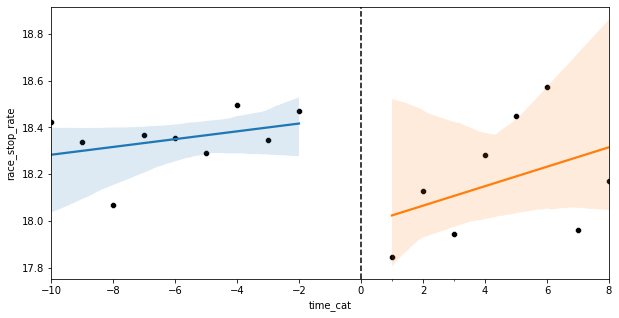

In [125]:
def plot(data_o, time_range=[-10,9]):
    data = copy(data_o)
    data = data[data['time_cat'].isin(range(time_range[0],time_range[1]))]
    data = data[~data['time_cat'].isin(range(-1,1))]

    data['time_cat'] = data['time_cat'] * 10
    data['race_stop_rate'] = data['race_stop_rate'] * 100

    # plot points
    figure(figsize=(10,5))
    ax = sns.scatterplot(x='time_cat', y='race_stop_rate', data=data, color='black')
    plt.axvline(0, c='black', linestyle='dashed')

    # two different regressions
    data_before = data[data['time_cat'] < -1]
    data_after = data[data['time_cat'] > 0]

    # plot regressions
    sns.regplot(x='time_cat', y='race_stop_rate', data=data_before, scatter=False)
    sns.regplot(x='time_cat', y='race_stop_rate', data=data_after, scatter=False)

    ax.set_xlabel('Time since dusk (min)')
    ax.set_ylabel('Percentage of stopped drivers who are black')

plot(data_black)

In [ ]:

# preprocess for grouping
data['search_rate'] = data['search_conducted']
data = data.astype({'search_rate': float})
data['count'] = 1 # to count occurences

# add specific column for this type of analyzis
df_yos['age_category'] = df_yos['officer_yos'].apply(lambda x : officer_experience_level[0] if x < thresholds_experience[0] else (officer_experience_level[1] if x < thresholds_experience[1] else officer_experience_level[2]))
df_yos_all = df_yos.groupby(['age_category','subject_race','county_name']).agg({'search_rate': 'mean', 'count':'count'})

# Logistic regression of characteristics of officers

In [ ]:
df_log_raw = copy(df)

# remove unused columns
df_log_raw = remove_general_unused_columns(df_log_raw)
df_log_raw.drop(columns=['arrest_made', 'citation_issued','warning_issued', 'outcome', 'frisk_performed'], inplace=True)
df_log_raw.dropna(inplace=True, subset=['search_conducted'])

# make sure that required data are present (drop if nan values in those columns)
important_features = ['subject_age', 'officer_yos', 'officer_age']
for feat in important_features:
    m = df_log_raw[feat].mean()
    df_log_raw[feat] = df_log_raw[feat].fillna((m))
print('Cleaned subset is composed of {} datapoints'.format(df_log_raw.shape[0]))

# overview of all the data / global search rate
print_search_rate(df_log_raw)

df_log_raw.head()

In [ ]:
# preprocess for regression
df_log = copy(df_log_raw)

print('Processing sub races')
sub_races = list(df_log['subject_race'].unique())
for race in sub_races:
    df_log['subject_' + (race if isinstance(race, str) else 'nan')] = (df_log['subject_race'] == race).apply(lambda x : int(x))

print('Processing off races')
off_races = list(df_log['officer_race'].unique())
for race in off_races:
    df_log['officer_' + (race if isinstance(race, str) else 'nan')] = (df_log['officer_race'] == race).apply(lambda x : int(x))

print('Processing sub genders')
sub_genders = list(df_log['subject_sex'].unique())
for gender in sub_genders:
    df_log['subject_' + (gender if isinstance(gender, str) else 'nan')] = (df_log['subject_sex'] == gender).apply(lambda x : int(x))

print('Processing off genders')
off_genders = list(df_log['officer_sex'].unique())
for gender in off_genders:
    df_log['officer_' + (gender if isinstance(gender, str) else 'nan')] = (df_log['officer_sex'] == gender).apply(lambda x : int(x))

print('Processing off yos')
cat_exp = [0, 2, 6, 10, 15, 100]
for infi in range(len(cat_exp) -1):
    df_log['officer_exp_' + str(cat_exp[infi]) ] = ( df_log['officer_yos'].between(cat_exp[infi],cat_exp[infi+1], inclusive=[True, False]) ) .apply(lambda x : int(x))

print('Processing off age')
cat_age = [15, 25, 35, 45, 55, 70, 100]
for infi in range(len(cat_age) -1):
    df_log['officer_age_' + str(cat_age[infi]) ] = ( df_log['officer_age'].between(cat_age[infi],cat_age[infi+1], inclusive=[True, False]) ) .apply(lambda x : int(x))


print('Processing search')
df_log['search_conducted'] = df_log['search_conducted'].apply(lambda x : int(x))

print('Removing old columns')
df_log.drop(columns=['subject_race', 'officer_race', 'subject_sex', 'officer_sex', 'officer_yos', 'officer_age'], inplace=True)

df_log.head()

In [ ]:
counties = df_log['county_name'].unique()
maxi = 0
maxi_c = 0
for c in counties:
    v = df_log[df_log['county_name'] == c].shape[0]
    if v > maxi:
        maxi = v
        maxi_c = c

print(maxi_c, maxi )

df_log = df_log[df_log['county_name'] == maxi_c].drop(columns='county_name')

In [ ]:
df_log.head()

In [ ]:
y = df_log['search_conducted'].to_numpy()
x = df_log.drop(columns='search_conducted').to_numpy()
print(x[0], y[0])

In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0)
clf.fit(x, y)
params = clf.coef_[0]

In [ ]:
print("Parameters of logistic regression are:")
for i, col in enumerate(df_log.drop(columns='search_conducted').columns):
    print(" - {} : {:.3f} ".format(col,params[i]))

In [ ]:
from xgboost import XGBClassifier, plot_importance, DMatrix

model = XGBClassifier()
model.fit(x, y)

In [ ]:
plot_importance(model).set_yticklabels(df_log.drop(columns='search_conducted').columns[:23])

We see that experienced officers do not search often people. This may be due because they are at a higher level, so they do not do the search themselves. 

# Old stuff

In [ ]:
def plot_officer_race(data, race):
    data_ = data[race]
    df_white_sub, df_black_sub, df_hispanic = data_.loc['white'], data_.loc['black'], data_.loc['hispanic'] #separate data
    df_white_sub.reset_index(inplace=True), df_black_sub.reset_index(inplace=True), df_hispanic.reset_index(inplace=True) #reset index
    df_merged = pd.merge(df_white_sub, df_black_sub, on='county_name', suffixes=['', '_black'])
    df_merged = pd.merge(df_merged, df_hispanic, on='county_name', suffixes=['_white', '_hispanic'])
    fig, ax_arr = plt.subplots(1, 2) # 2 graphs
    fig.set_size_inches(9,5) # fig size

    fig.suptitle("Minorities search rates of {} officers".format(race))

    ax_arr[0].scatter(df_merged['search_rate_white']*100, df_merged['search_rate_black']*100)
    ax_arr[0].set_xlabel("White search rate (%)")
    ax_arr[0].set_ylabel("Black search rate (%)")

    ax_arr[1].scatter(df_merged['search_rate_white']*100, df_merged['search_rate_hispanic']*100)
    ax_arr[1].set_xlabel("White search rate (%)")
    ax_arr[1].set_ylabel("Black search rate (%)")
    

for race in officer_race:
    plot_officer_race(df_officers, race)